### Introduction

Monte Carlo experiments are a class of computational algorithms that approximate complex outcomes by repeatedly generating random samples. It's widely used in fields as diverse as finance, science, and engineering to model uncertainty and make informed decisions. By simulating many possible scenarios, it provides insight into the range of possible outcomes and their probabilities. Input variables are sampled within defined ranges, which are then used to perform calculations and aggregate the results. In this way, the probabilities or the characteristics of the system can be estimated.

In this case, the Monte Carlo method generates fermentation data by feeding random sets of parameters as input to the mechanistic model. The generated batches still have a batch phase and a fed-batch phase as in the original experiment because the glucose feed and total feed are kept the same as in the original experiment. To have variation in the two required parameter sets, a normal distribution is generated for each parameter, with the parameter value from the optimal parameter set as the mean. Additionally, the variance is needed for each parameter. In order to have a normal distribution in the range of 75% of the parameter value as a lower bound and 125% of the parameter value as an upper bound, it is defined that 95% of the generated values are within this range. Based on this information, the following equation is developed:
$ \sigma = \frac{upper\space bound - lower\space bound}{4} $ because 4 times the variance is defined as covering 95% of the distribution.

<img src="images/normal_distribution.svg"
     alt="https://upload.wikimedia.org/wikipedia/commons/8/8c/Standard_deviation_diagram.svg"
     style="float: center"
     width="600" />

The result are 500 parameter combinations for each set 1 and set 2. The sets are combined and fed to the mechanistic model. After calculating the biomass, substrate and co2 values for the whole fermentation, white noise is added. The data of the 500 generated batches are saved in a dataframe (data/batch_no2/generated data/df_gen_co2_2.csv). A plot of one batche is shown in the code.

### Code

In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from E_model import model_S_no2, show_plot_no2

pd.options.mode.chained_assignment = None  # Suppress the warning

In [2]:
# Load parameters from YAML file
with open('config/parameters.yml', 'r') as file:
    param = yaml.safe_load(file)

set1 = param['set_part1']
set2 = param['set_part2']

In [3]:
df_exp = pd.read_csv('data/batch_no2/data_combined.csv')

**Set 1: Batch Phase**

In [4]:
num_samples = 500 # number of batches generated

# Bounds for the distribution
lb = 0.75
ub = 1.25

p1 = set1
print(p1)

Yxs_dist = np.random.normal(p1[0], ((ub*p1[0] - lb*p1[0]) / 4), num_samples)
Yco2s_dist = np.random.normal(p1[1], ((ub*p1[1] - lb*p1[1]) / 4), num_samples)
qs_max_dist = np.random.normal(p1[2], ((ub*p1[2] - lb*p1[2]) / 4), num_samples)
Ks_dist = np.random.normal(p1[3], ((ub*p1[3] - lb*p1[3]) / 4), num_samples)
m_s_dist = np.random.normal(p1[4], ((ub*p1[4] - lb*p1[4]) / 4), num_samples)
lag_dist = np.random.normal(p1[5], ((ub*p1[5] - lb*p1[5]) / 4), num_samples)

df_p1 = pd.DataFrame({
    'Yxs': Yxs_dist,
    'Yco2s': Yco2s_dist,
    'qs_max': qs_max_dist,
    'Ks': Ks_dist,
    'm_s': m_s_dist,
    'lag': lag_dist})

df_p1.describe()

[0.554746, 0.003358, 1.276025, 0.687328, 0.034399, 0.226874]


,Yxs,Yco2s,qs_max,Ks,m_s,lag
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.548903,0.003346,1.277841,0.694687,0.034447,0.225993
std,0.071345,0.000415,0.158257,0.089163,0.004237,0.029086
min,0.338739,0.001990,0.846015,0.443686,0.022497,0.150286
25%,0.497731,0.003083,1.179682,0.637165,0.031581,0.206268
50%,0.547731,0.003371,1.277509,0.696180,0.034573,0.225701
75%,0.594222,0.003636,1.382776,0.749041,0.037220,0.244834
max,0.766731,0.004529,1.696126,1.025074,0.046019,0.312390


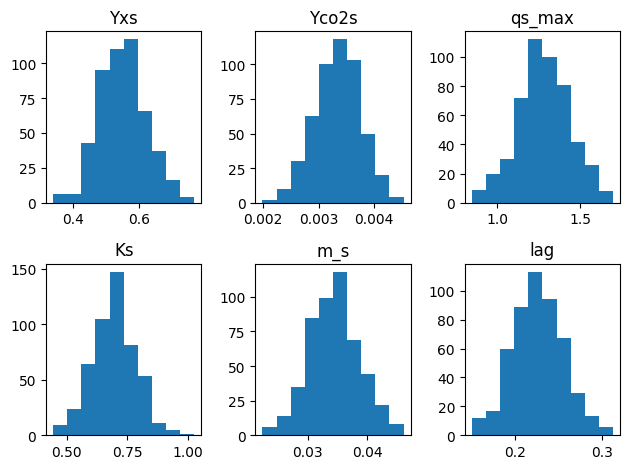

In [5]:
# check if there are enough samples to have a normal distribution
fig, ax = plt.subplots(2, 3)
ax[0,0].hist(df_p1['Yxs'])
ax[0,0].set_title('Yxs')
ax[0,1].hist(df_p1['Yco2s'])
ax[0,1].set_title('Yco2s')
ax[0,2].hist(df_p1['qs_max'])
ax[0,2].set_title('qs_max')
ax[1,0].hist(df_p1['Ks'])
ax[1,0].set_title('Ks')
ax[1,1].hist(df_p1['m_s'])
ax[1,1].set_title('m_s')
ax[1,2].hist(df_p1['lag'])
ax[1,2].set_title('lag')
plt.tight_layout()

**Set 2: Fed-batch Phase**

In [6]:
p2 = set2
print(p2)

Yxs_dist = np.random.normal(p2[0], ((ub*p2[0] - lb*p2[0]) / 4), num_samples)
Yco2s_dist = np.random.normal(p2[1], ((ub*p2[1] - lb*p2[1]) / 4), num_samples)
qs_max_dist = np.random.normal(p2[2], ((ub*p2[2] - lb*p2[2]) / 4), num_samples)
Ks_dist = np.random.normal(p2[3], ((ub*p2[3] - lb*p2[3]) / 4), num_samples)
m_s_dist = np.random.normal(p2[4], ((ub*p2[4] - lb*p2[4]) / 4), num_samples)
lag_dist = np.random.normal(p2[5], ((ub*p2[5] - lb*p2[5]) / 4), num_samples)

df_p2 = pd.DataFrame({
    'Yxs': Yxs_dist,
    'Yco2s': Yco2s_dist,
    'qs_max': qs_max_dist,
    'Ks': Ks_dist,
    'm_s': m_s_dist,
    'lag': lag_dist})

df_p2.describe()

[0.843, 0.0048, 2.166, 0.527, 0.045, 0.0]


,Yxs,Yco2s,qs_max,Ks,m_s,lag
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.0
mean,0.840555,0.004818,2.165848,0.524807,0.045277,0.0
std,0.105360,0.000585,0.275489,0.065652,0.005413,0.0
min,0.475229,0.003253,1.400343,0.340414,0.026832,0.0
25%,0.775696,0.004437,1.965890,0.479042,0.041669,0.0
50%,0.838022,0.004833,2.166184,0.528059,0.045073,0.0
75%,0.910429,0.005202,2.363370,0.569325,0.049343,0.0
max,1.121327,0.006701,3.306095,0.685250,0.063962,0.0


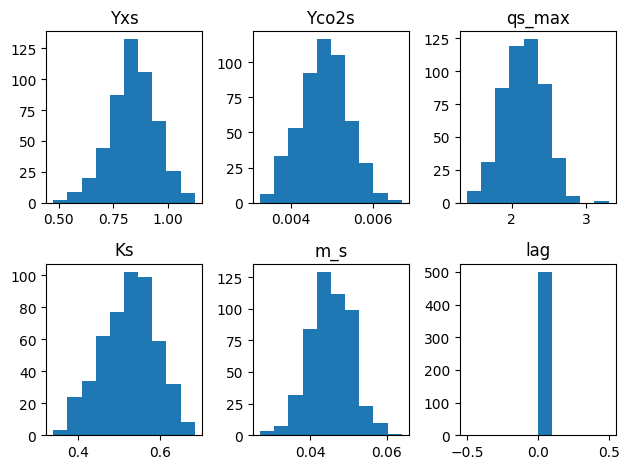

In [7]:
# check if there are enough samples to have a normal distribution
fig, ax = plt.subplots(2, 3)
ax[0,0].hist(df_p2['Yxs'])
ax[0,0].set_title('Yxs')
ax[0,1].hist(df_p2['Yco2s'])
ax[0,1].set_title('Yco2s')
ax[0,2].hist(df_p2['qs_max'])
ax[0,2].set_title('qs_max')
ax[1,0].hist(df_p2['Ks'])
ax[1,0].set_title('Ks')
ax[1,1].hist(df_p2['m_s'])
ax[1,1].set_title('m_s')
ax[1,2].hist(df_p2['lag'])
ax[1,2].set_title('lag')
plt.tight_layout()

**Data Generation with the generated parameter sets as input**

In [8]:
# Set the noise parameters
mean = 0  # Mean of the noise
std_dev = 0.1  # Standard deviation of the noise
std_dev_co2 = 0.001  # Standard deviation of the noise

In [9]:
# define sample frequency
# --> higher frequency reduces the amount of data that has to be stored (less data points)
delta_t = 2 #min

df_batches = pd.DataFrame()
for i in range(df_p1.shape[0]):
    batch_id = str(i).zfill(3)
    set1 = list(df_p1.iloc[i])
    set2 = list(df_p2.iloc[i])
    df = model_S_no2(set1, set2, delta_t)
    df['batch_id'] = str(batch_id)
    
    # Add noise to the 'biomass' column
    noise_biomass = np.random.normal(mean, std_dev, df.shape[0])
    df['biomass'] += noise_biomass

    # Add noise to the 'co2' column
    noise_co2 = np.random.normal(mean, std_dev_co2, df.shape[0])
    df['co2'] += noise_co2
    
    # Add noise to the 'glucose' column
    noise_glucose = np.random.normal(mean, std_dev, df.shape[0])
    df['glucose'] += noise_glucose

    df_batches = pd.concat([df_batches, df], ignore_index=True)

df_batches.to_csv('data/batch_no2/generated data/df_gen.csv')

**Visualization of one batch out of 500 batches**

In [10]:
df_gen = pd.read_csv('data/batch_no2/generated data/df_gen.csv')
df_gen.drop(['Unnamed: 0'], axis=1, inplace=True)
df_gen['batch_id'] = df_gen['batch_id'].astype(str).str.zfill(3)

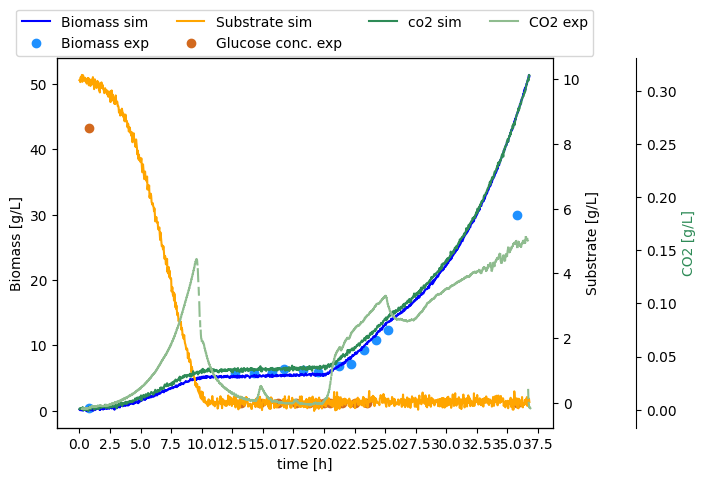

In [11]:
df_one = df_gen[df_gen['batch_id'] == '001']
show_plot_no2(df_one)

**Visualization of all batches**

In [12]:
# biomass
df_X = df_gen.copy().drop(['glucose', 'co2'], axis=1)
sorted_X = df_X.groupby('batch_id')['biomass'].max().sort_values(ascending=False).index
df_X['batch_id'] = pd.Categorical(df_X['batch_id'], categories=sorted_X, ordered=True)
df_X = df_X.sort_values(['batch_id', 'time'], ascending=[True, True])

# glucose
df_S = df_gen.copy().drop(['biomass', 'co2'], axis=1)
sorted_S = df_S.groupby('batch_id')['glucose'].max().sort_values(ascending=False).index
df_S['batch_id'] = pd.Categorical(df_S['batch_id'], categories=sorted_S, ordered=True)
df_S = df_S.sort_values(['batch_id', 'time'], ascending=[True, True])

# co2
df_co2 = df_gen.copy().drop(['biomass', 'glucose'], axis=1)
sorted_qs = df_co2.groupby('batch_id')['co2'].max().sort_values(ascending=False).index
df_co2['batch_id'] = pd.Categorical(df_co2['batch_id'], categories=sorted_qs, ordered=True)
df_qs = df_co2.sort_values(['batch_id', 'time'], ascending=[True, True])

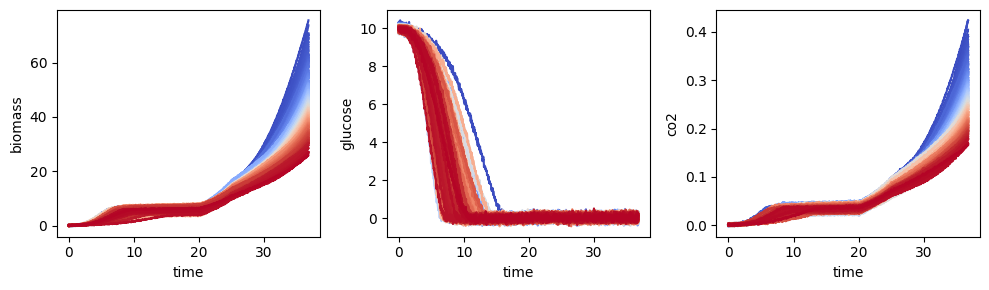

In [13]:
# Rainbow palette: Spectral
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

sns.lineplot(ax=ax[0], data=df_X, x='time', y='biomass', hue='batch_id', palette='coolwarm', legend=False)
sns.lineplot(ax=ax[1], data=df_S, x='time', y='glucose', hue='batch_id', palette='coolwarm', legend=False)
sns.lineplot(ax=ax[2], data=df_co2, x='time', y='co2', hue='batch_id', palette='coolwarm', legend=False)

plt.tight_layout()
plt.show()